In [4]:
!pip install basicsr

  Using cached basicsr-1.4.2.tar.gz (172 kB)
  Preparing metadata (setup.py) ... done
  Obtaining dependency information for tb-nightly from https://files.pythonhosted.org/packages/a9/e3/e0961ec60b3029f5fcab6ff6792b80ba6d13d69b8ebd7ca15f0dadedb17c/tb_nightly-2.18.0a20240611-py3-none-any.whl.metadata
  Obtaining dependency information for tensorboard-data-server<0.8.0,>=0.7.0 from https://files.pythonhosted.org/packages/73/c6/825dab04195756cf8ff2e12698f22513b3db2f64925bdd41671bfb33aaa5/tensorboard_data_server-0.7.2-py3-none-manylinux_2_31_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 26.5 MB/s eta 0:00:0000:0100:01
Using cached tensorboard_data_server-0.7.2-py3-none-manylinux_2_31_x86_64.whl (6.6 MB)
  Created wheel for basicsr: filename=basicsr-1.4.2-py3-none-any.whl size=214818 sha256=541603deca7d5de350418153dc0805bffc3cfcac981577b62208f08e5308aeda
  Stored in directory: /home/jovyan/.cache/pip/wheels/38/83/99/2d8437cc652a01af27df5ff037a4075e95b52d67705c5f

In [18]:
from share import *
import config

import cv2
import einops
import numpy as np
import torch
import random
from PIL import Image

from pytorch_lightning import seed_everything
from annotator.util import resize_image, HWC3
from annotator.midas import MidasDetector
from annotator.canny import CannyDetector
from cldm.model import create_model, load_state_dict
from cldm.ddim_hacked import DDIMSampler

In [2]:
image_orig_path = './test_imgs/o1.png'
prompt = "Make the temple a church"

In [3]:
orig = cv2.imread(image_orig_path)

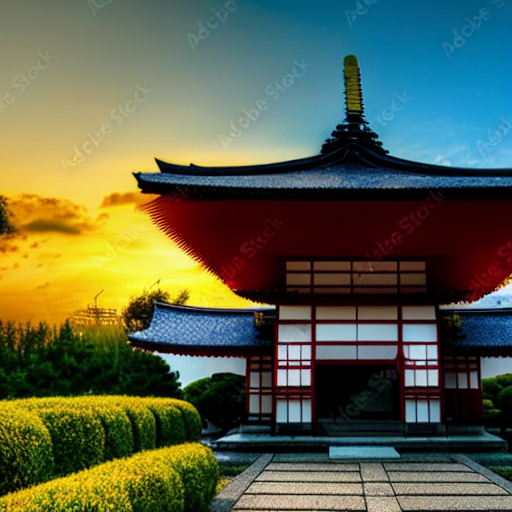

In [4]:
Image.fromarray(cv2.cvtColor(orig, cv2.COLOR_BGR2RGB), "RGB")

In [5]:
# apply_midas = MidasDetector()

model = create_model('./models/cldm_v15.yaml').cpu()
model.load_state_dict(load_state_dict('../../../fcheck/control_sd15_normal.pth', location='cuda'))
model = model.cuda()
ddim_sampler = DDIMSampler(model)

/opt/conda/lib/python3.10/site-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name vit_base_resnet50_384 to current vit_base_r50_s16_384.orig_in21k_ft_in1k.
  model = create_fn(


No module 'xformers'. Proceeding without it.
ControlLDM: Running in eps-prediction mode
DiffusionWrapper has 859.52 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels
Loaded model config from [./models/cldm_v15.yaml]
Loaded state_dict from [../../../fcheck/control_sd15_normal.pth]


In [19]:
apply_canny = CannyDetector()

In [6]:
A_PROMPT_DEFAULT = "best quality, extremely detailed"
N_PROMPT_DEFAULT = "longbody, lowres, bad anatomy, bad hands, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality"

In [20]:
def run_sampler(
    model,
    input_image: np.ndarray,
    prompt: str,
    num_samples: int = 1,
    image_resolution: int = 512,
    seed: int = -1,
    a_prompt: str = A_PROMPT_DEFAULT,
    n_prompt: str = N_PROMPT_DEFAULT,
    guess_mode=False,
    strength=1.0,
    ddim_steps=20,
    eta=0.0,
    scale=9.0,
    show_progress: bool = True,
    bg_threshold=0.4
):
    with torch.no_grad():
        if torch.cuda.is_available():
            model = model.cuda()
        
        img = resize_image(HWC3(input_image), image_resolution)
        H, W, C = img.shape

        detected_map = apply_canny(img, 100, 200)
        detected_map = HWC3(detected_map)
        
        # input_image = HWC3(input_image)
        # _, detected_map = apply_midas(resize_image(input_image, 512), bg_th=bg_threshold)
        # detected_map = HWC3(input_image)
        # img = resize_image(input_image, image_resolution)
        # H, W, C = img.shape
        
        # detected_map = cv2.resize(detected_map, (W, H), interpolation=cv2.INTER_LINEAR)


        control = torch.from_numpy(input_image.copy()).float().cuda() / 255.0
        control = torch.stack([control for _ in range(num_samples)], dim=0)
        control = einops.rearrange(control, 'b h w c -> b c h w').clone()


        if seed == -1:
            seed = random.randint(0, 65535)
        seed_everything(seed)

        if config.save_memory:
            model.low_vram_shift(is_diffusing=False)

        cond = {
            "c_concat": [control],
            "c_crossattn": [
                model.get_learned_conditioning([prompt + ", " + a_prompt] * num_samples)
            ],
        }
        un_cond = {
            "c_concat": None if guess_mode else [control],
            "c_crossattn": [model.get_learned_conditioning([n_prompt] * num_samples)],
        }
        shape = (4, 512 // 8, 512 // 8)

        if config.save_memory:
            model.low_vram_shift(is_diffusing=True)

        model.control_scales = (
            [strength * (0.825 ** float(12 - i)) for i in range(13)]
            if guess_mode
            else ([strength] * 13)
        )  # Magic number. IDK why. Perhaps because 0.825**12<0.01 but 0.826**12>0.01
        samples, intermediates = ddim_sampler.sample(
            ddim_steps,
            num_samples,
            shape,
            cond,
            verbose=False,
            eta=eta,
            unconditional_guidance_scale=scale,
            unconditional_conditioning=un_cond,
            show_progress=show_progress,
        )

        if config.save_memory:
            model.low_vram_shift(is_diffusing=False)

        x_samples = model.decode_first_stage(samples)
        x_samples = (
            (einops.rearrange(x_samples, "b c h w -> b h w c") * 127.5 + 127.5)
            .cpu()
            .numpy()
            .clip(0, 255)
            .astype(np.uint8)
        )

        results = [x_samples[i] for i in range(num_samples)]

        return [detected_map] + results

In [21]:
r = run_sampler(model, orig, prompt, seed=42)

Seed set to 42


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.70it/s]


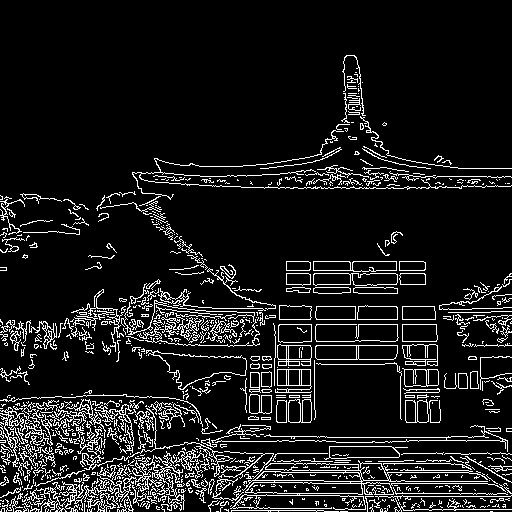

In [22]:
Image.fromarray(r[0], "RGB")

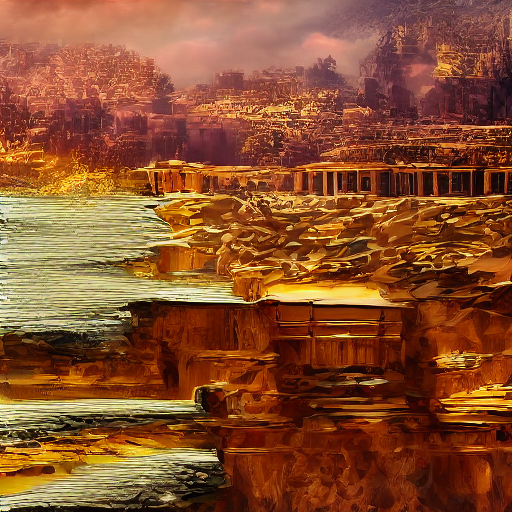

In [23]:
Image.fromarray(r[1], "RGB")